In [4]:
# You can import *ANYTHING* you want here.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.
from sklearn.model_selection import GridSearchCV, train_test_split

import pandas as pd

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


# Assignment 8: Tree methods

In this assignment we'll study tree methods and their capabilities as interpolators and extrapolators, and the importance of understanding your data. We will use a dataset of energy consumption of home appliances for houses in Chievres, Belgium. The data has the following variables:

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh (**Target variable**)energy_extrapolation
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), in C degrees

You are given two datasets: energy_appliances_standard.csv and energy_appliances_extrapolation.csv. The first dataset has typical consumption patterns, while the second one has the top 10% highest consumptions and will be used to test the extrapolating capacities of our models.


## Task 1: Random Forests (35/100)

Random Forests are excellent predictors. Usually we only need to tune one parameter: the number of trees in the model. However, how many trees are enough? Follow these steps:

1. Load the training dataset (energy_appliances_standard.csv) and show the descriptive statistics of the variables. (3 pts)

2. Create a train / test partition of the data using 30% of the data for the test set and a ```random_state``` value of 20201107(2 pts).

3. Follow [this example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) and train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using ```Appliances``` as the target variable. Test between 50 and 250 trees, plotting the Out-of-Bag (OOB) error after every iteration. Be patient as training can take a while. Written answer: What is the optimal number of trees for your model and why do you think this? (15 pts)

4. Train your final random forest with the number of trees you selected in part 3. Apply this model over your test set and over the extrapolating dataset (from the file ```energy_appliances_extrapolation.csv```), calculating the mean absolute percentual error for each dataset.  Show in a scatterplot the predicted value vs the real value of the target variable for both the test set and the extrapolation set (in the same plot), differentiating both by using different colors for the points. Written answer: How does the random forest model perform on predicting Appliance energy usage in the extrapolation data set? If it performs poorly, why? If it performs well, why? *Hint: look at the scatterplot*. (15 points)

In [2]:
# Data load
df = pd.read_csv("energy_appliances_standard.csv")

In [3]:
# Create train / test split
X = df.drop(["Appliances"], axis = 'columns')
y = df.Appliances

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 20201107)

In [42]:
# Define random forest and iterate over the number of trees
rf_regressor = RandomForestRegressor(warm_start=False,
                                      oob_score=True,
                                      max_features="sqrt",
                                      random_state=20201107)
error_rate = []
min_estimators = 50
max_estimators = 250
for i in range(min_estimators, max_estimators + 1):
    rf_regressor.set_params(n_estimators=i)
    rf_regressor.fit(Xtrain, ytrain)
    oob_error = 1 - rf_classifier.oob_score_
    error_rate.append((i, oob_error))

KeyboardInterrupt: 

No handles with labels found to put in legend.


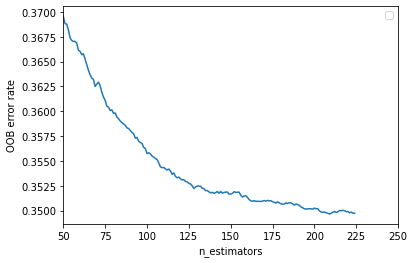

In [10]:
# Plot the OOB error per number of trees
xs, ys = zip(*error_rate)
plt.plot(xs, ys)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

**Written answer:**150 is the optimal number of trees for my model,since the OOB error starts to become stable.

In [15]:
# Final forest
rf_regressor.set_params(n_estimators=150)
rf_regressor.fit(Xtrain, ytrain)

# Calculate error over test set
ytest_pred = rf_regressor.predict(Xtest)
error_test_set = ytest - ytest_pred
# Load the second dataset
data_extra = pd.read_csv("energy_appliances_extrapolation.csv")
Xextra = data_extra.drop(["Appliances"], axis = 'columns')
yextra = data_extra.Appliances
# Calculate the error over it
yextra_pred = rf_regressor.predict(Xextra)
error_extra_set = yextra - yextra_pred

In [16]:
# Print MAPE over the sets
test_mape = np.mean(np.abs(error_test_set / ytest))
print(test_mape)
extra_mape = np.mean(np.abs(error_extra_set / yextra))
print(extra_mape)


0.18737568047991784
0.6997912204061078


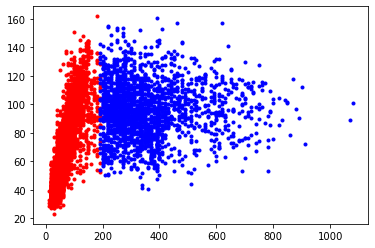

In [17]:
# Make the scatterplot
plt.plot(ytest,  ytest_pred,  "r.")
plt.plot(yextra, yextra_pred, "b.")

**Written answer: **it performs poorly because the y-axis range for two sets(test set and the extrapolation set) of data are compeletly different

## Task 2: XGBoosting model (40 pts)

Now we'll repeat the process for the XGB model, using an [```XGBRegressor``` object](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The XGBoosting model is much more sensitive to parameter changes though as it allows to tune many different parameters. For this example:

1. Written answer: Why do we say we want to use a small learning rate? Why do we say the number of trees to use depends on each dataset/problem? Why do we want to use a small tree depth? (6 pts)

2. Selecting a 30% validation sample over the training set, tune your parameters using crossvalidation. Use the following ranges:
 - Learning rate: [0.01, 0.1, 0.2].
 - max_depth: 3 to 7.
 - Number of trees: [350, 400, 450, 500]

Leave the other parameters at the values we identified in the lab (except for the objective parameter and those related to classification problems) and use a seed of 20201107. Report the optimal values of your parameters. (20 pts)

3. Repeat part 4 of the previous task, but now for your XGB model trained over the optimal parameter combination and the complete training dataset. Plot the variable importance. Written answer: What are the most important variables? Can the XGB model extrapolate? How does it compare to a random forest? (14 pts)

**Written answer part 1 (2 pts each):**
A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights.

In [14]:
# Define the XGB model
XGB_regressor = XGBRegressor(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [23]:
# Create reduced validation set.
data_train, data_test = train_test_split(df, test_size = 0.3,random_state = 20201107)  
data_validation = df.sample(frac = 0.3, random_state = 20201107)
# Define the parameter grid.
param_grid = dict({'n_estimators': [350, 400, 450, 500],
                   'max_depth': [3, 4, 5, 6, 7],
                   'learning_rate' : [0.01, 0.1, 0.2]
                  })

In [30]:
# Train grid search. This takes a while! Go grab a coffee.
GridXGB = GridSearchCV(XGB_regressor,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       n_jobs = -1,         # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )
GridXGB.fit(data_validation.iloc[:, 1:], data_validation.Appliances)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.001,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_child_weight=None,
                                    missing=None, monotone_constraints=None,
                                    n_estimators=100, n_jobs=2,
                                    num_parallel_tree=None,
                                    random_state=20201107, reg_alpha=1,
                                    reg_lambda=0, scale_pos_weight=1,
                                    subsample=1, tree_method=None,
                                    validate_parameters=None, verbos

In [31]:
# Show best params
GridXGB.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 350}

In [32]:
# Train final XGB with optimal parameters
XGB_regressor = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                              learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                              n_estimators=GridXGB.best_params_.get('n_estimators'),
                              random_state=20201107)
XGB_regressor.fit(data_train.iloc[:, 1:], data_train.Appliances)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=350, n_jobs=0, num_parallel_tree=1,
             random_state=20201107, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

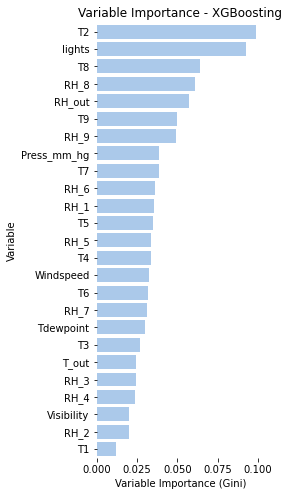

In [33]:
# Variable importance
importances = XGB_regressor.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[data_train.iloc[:, 1:].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

**Written answer:**T2, lights and T8 are important

0.1991134605310149
0.6918849187574005


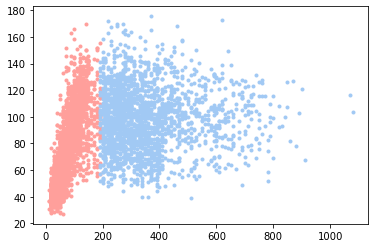

In [34]:
# Make scatterplot
ytest_pred = XGB_regressor.predict(Xtest)
error_test_set = ytest - ytest_pred

yextra_pred = XGB_regressor.predict(Xextra)
error_extra_set = yextra - yextra_pred
test_mape = np.mean(np.abs(error_test_set / ytest))
print(test_mape)
extra_mape = np.mean(np.abs(error_extra_set / yextra))
print(extra_mape)
plt.plot(ytest,  ytest_pred,  "r.")
plt.plot(yextra, yextra_pred, "b.")

**Written answer: **the XGB model cannot extrapolate but it a little bit better than a  random forest


## Task 3: Combined model (25 pts)

Now we will finally train a model on the combined data, by joining the extrapolation and the original dataset, and study the performance over the original test set, the new test set and the combined result. For this we will only use the Random Forest model. Use a seed of 20201107 for all functions that accept one.

1. Create a train / test split set over the extrapolation data, leaving approximately 30% of the data for testing purposes. Combine this train test with the original train set (let's call this the combined train set). (5 pts)
2. Train a Random Forest model over the **combined** train data. Discuss how many trees you used and why. (15 pts)
3. Plot the variable importance and compare it versus the XGB in task 1. Now that you more data, does the importance change? (5 pts)
3. Report the test set performance of your new model over the original test set, the test set you took over the extrapolation dataset and the combined test set. Plot the scatterplot of the both datasets as before in the same plot, differentiating the dataset by using colours. (10 pts)

Written answer: What happens now? What can you say about the new model?

In [43]:
# Create the new train and test set.
X_std = df.drop(["Appliances"], axis = 'columns')
y_std = df.Appliances

Xtrain_std, Xtest_std, ytrain_std, ytest_std = train_test_split(X_std, y_std, test_size = 0.3, random_state = 20201107)

X_extra = data_extra.drop(["Appliances"], axis = 'columns')
y_extra = data_extra.Appliances

Xtrain_extra, Xtest_extra, ytrain_extra, ytest_extra = train_test_split(X_extra, y_extra, test_size = 0.3, random_state = 20201107)

Xtrain_comb = pd.concat([Xtrain_std, Xtrain_extra])
ytrain_comb = pd.concat([ytrain_std, ytrain_extra])

Xtest_comb = pd.concat([Xtest_std, Xtest_extra])
ytest_comb = pd.concat([ytest_std, ytest_extra])



In [45]:
# Obtain the new random forest (tune the trees)
rf_regressor = RandomForestRegressor(warm_start=False,
                                      oob_score=True,
                                      max_features="sqrt",
                                      random_state=20201107)
error_rate = []
min_estimators = 50
max_estimators = 250

for i in range(min_estimators, max_estimators + 1):
    rf_regressor.set_params(n_estimators=i)
    rf_regressor.fit(Xtrain_comb, ytrain_comb)
    
    oob_error = 1 - rf_regressor.oob_score_
    error_rate.append((i, oob_error))


KeyboardInterrupt: 

In [2]:
import skleran
print(sklearn.__verison__)

ModuleNotFoundError: No module named 'skleran'

No handles with labels found to put in legend.


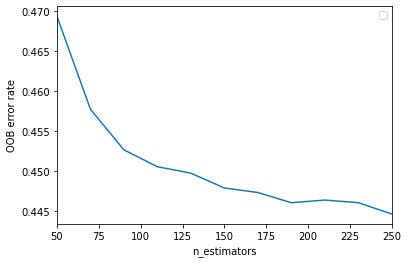

RandomForestRegressor(max_features='sqrt', n_estimators=150, oob_score=True,
                      random_state=20201107)

In [38]:
xs, ys = zip(*error_rate)
plt.plot(xs, ys)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()
rf_regressor.set_params(n_estimators=150)
rf_regressor.fit(Xtrain_comb, ytrain_comb)

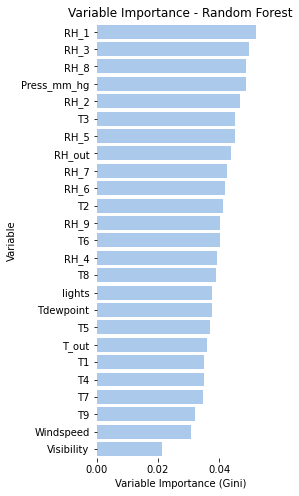

In [39]:
# Variable importance
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[Xtrain_comb.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

**Written answer: **the importance of variable in task3 are smilar weighted, however the weight of importance of variable in task2 are pretty different from each other.

In [40]:
# Print MAPE over the test sets
ytest_pred_std = rf_regressor.predict(Xtest_std)
error_std = ytest_std - ytest_pred_std
mape_std = np.mean(np.abs(error_std / ytest_std))
print(mape_std)

ytest_pred_extra = rf_regressor.predict(Xtest_extra)
error_extra = ytest_extra - ytest_pred_extra
mape_extra = np.mean(np.abs(error_extra / ytest_extra))
print(mape_extra)

ytest_pred_comb = rf_regressor.predict(Xtest_comb)
error_comb = ytest_comb - ytest_pred_comb
mape_comb = np.mean(np.abs(error_comb / ytest_comb))
print(mape_comb)

0.3236993567436566
0.3491594937185924
0.3262793402236363


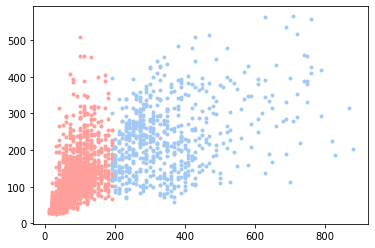

In [41]:
# Scatterplot
plt.plot(ytest_std,   ytest_pred_std,   "r.")
plt.plot(ytest_extra, ytest_pred_extra, "b.")

**Written answer:**we can see from the MAPE, it performs better than previous models.